In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.00'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models,Model,Input
train_path='/kaggle/input/updated-training-data/updated_dataset/training'
test_path='/kaggle/input/updated-training-data/updated_dataset/testing'
val_path='/kaggle/input/updated-training-data/updated_dataset/validation'

2025-11-04 14:06:46.169496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762265206.370412      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762265206.423109      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,#Normalize the pixel values to [0,255]
    horizontal_flip=True,# Randomly flips images horizontally—great for symmetry-based features
    width_shift_range=0.2,#Shifts images horizontally by up to 20% of the width
    height_shift_range=0.2,# Shifts images vertically by up to 20% of the height
    shear_range=0.2,# Applies shear transformations-slanting the image
    zoom_range=0.2, # Randomly zooms in on images by up to 20%
    rotation_range=30,# Rotates images randomly within a range of ±30 degrees
    fill_mode='nearest'# Fills in pixels that are created during transformations using the nearest pixel values
)

In [4]:
val_test_datagen=ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical'
)

Found 9992 images belonging to 8 classes.


In [6]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 2000 images belonging to 8 classes.


In [7]:
val_data=val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 2000 images belonging to 8 classes.


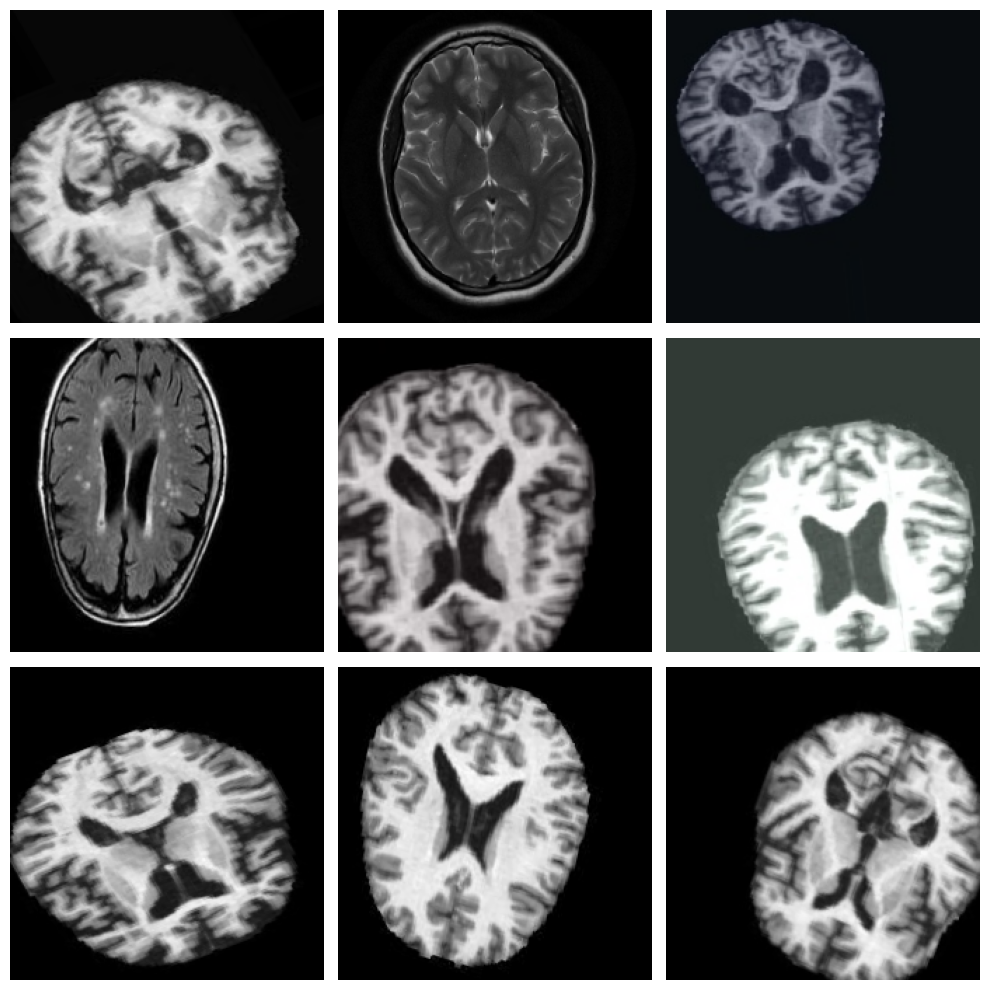

In [8]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
def count_images_per_class(generator,split_name=""):
    class_labels=list(generator.class_indices.keys())  
    counts=np.bincount(generator.classes)  
    print(f"\n{split_name} set distribution:")
    for label,count in zip(class_labels,counts):
        print(f"{label}:{count} images")
    print(f"Total:{sum(counts)} images")
count_images_per_class(train_data,"Training")
count_images_per_class(val_data,"Validation")
count_images_per_class(test_data,"Testing")


Training set distribution:
MildDemented:1499 images
ModerateDemented:1499 images
NonDemented:1499 images
VeryMildDemented:1499 images
glioma:999 images
meningioma:999 images
notumor:999 images
pituitary:999 images
Total:9992 images

Validation set distribution:
MildDemented:300 images
ModerateDemented:300 images
NonDemented:300 images
VeryMildDemented:300 images
glioma:200 images
meningioma:200 images
notumor:200 images
pituitary:200 images
Total:2000 images

Testing set distribution:
MildDemented:300 images
ModerateDemented:300 images
NonDemented:300 images
VeryMildDemented:300 images
glioma:200 images
meningioma:200 images
notumor:200 images
pituitary:200 images
Total:2000 images


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [11]:
print(class_weights_dict)

{0: 0.8332221480987325, 1: 0.8332221480987325, 2: 0.8332221480987325, 3: 0.8332221480987325, 4: 1.2502502502502502, 5: 1.2502502502502502, 6: 1.2502502502502502, 7: 1.2502502502502502}


In [12]:
from tensorflow.keras.applications import ResNet152V2
base_model=ResNet152V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

I0000 00:00:1762265239.897762      37 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1762265239.900041      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [13]:
base_model.trainable=False

In [14]:
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=1024,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=512,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.25),
    layers.Dense(units=256,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Dense(units=128,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.15),
    layers.Dense(units=64,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=8,activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,135,560 (233.21 MB)

 Trainable params: 2,799,944 (10.68 MB)

 Non-trainable params: 58,335,616 (222.53 MB)

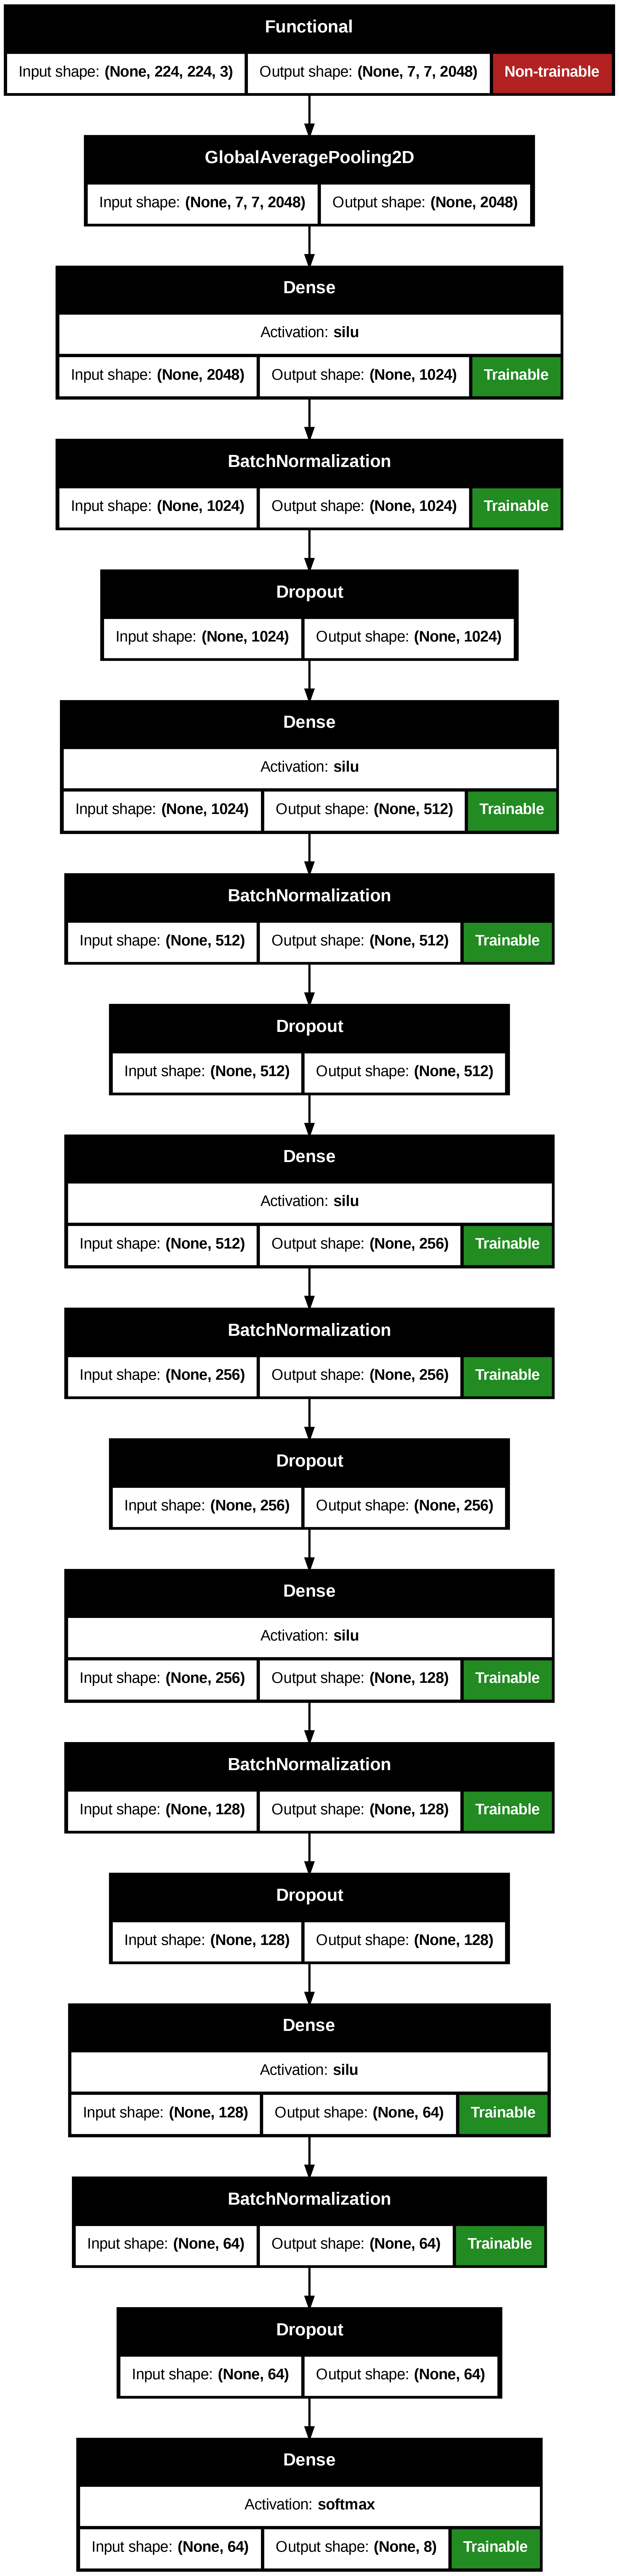

In [15]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    dpi=300,
    show_layer_activations=True,
    show_trainable=True
)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC,TopKCategoricalAccuracy
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=5,name='top5'),AUC(name='auc')])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)

In [18]:
history1=model.fit(train_data,validation_data=val_data,epochs=50,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1762265297.934698     122 service.cc:148] XLA service 0x792f24031710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762265297.935457     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762265302.047849     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/313 ━━━━━━━━━━━━━━━━━━━━ 3:43:33 43s/step - accuracy: 0.1562 - auc: 0.4898 - loss: 2.8595 - top5: 0.5625

I0000 00:00:1762265311.158019     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 532ms/step - accuracy: 0.3133 - auc: 0.7280 - loss: 1.9235 - top5: 0.8561 - val_accuracy: 0.5600 - val_auc: 0.9243 - val_loss: 1.0151 - val_top5: 0.9995
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 375ms/step - accuracy: 0.5102 - auc: 0.8908 - loss: 1.1598 - top5: 0.9826 - val_accuracy: 0.6590 - val_auc: 0.9509 - val_loss: 0.8159 - val_top5: 1.0000
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 397ms/step - accuracy: 0.5765 - auc: 0.9211 - loss: 0.9820 - top5: 0.9944 - val_accuracy: 0.6765 - val_auc: 0.9591 - val_loss: 0.7401 - val_top5: 1.0000
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 389ms/step - accuracy: 0.6072 - auc: 0.9336 - loss: 0.8983 - top5: 0.9977 - val_accuracy: 0.6885 - val_auc: 0.9629 - val_loss: 0.7004 - val_top5: 1.0000
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 376ms/step - accuracy: 0.6236 - auc: 0.9387 - loss: 0.8559 - top5: 0.9974 - val_accuracy: 0.7250 - val_auc: 0.9670 - val_loss: 0.6648 - val_top5: 1.0000
Epoch 6/50
313/313 ━━

In [19]:
base_model.trainable=True

In [20]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=5,name='top5'),AUC(name='auc')])

In [21]:
history2=model.fit(train_data,validation_data=val_data,epochs=25,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 374s 624ms/step - accuracy: 0.6356 - auc: 0.9312 - loss: 0.9357 - top5: 0.9891 - val_accuracy: 0.7815 - val_auc: 0.9789 - val_loss: 0.5244 - val_top5: 1.0000
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 389ms/step - accuracy: 0.7304 - auc: 0.9687 - loss: 0.5893 - top5: 0.9979 - val_accuracy: 0.8065 - val_auc: 0.9838 - val_loss: 0.4565 - val_top5: 1.0000
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 395ms/step - accuracy: 0.7897 - auc: 0.9811 - loss: 0.4441 - top5: 0.9998 - val_accuracy: 0.8335 - val_auc: 0.9884 - val_loss: 0.3815 - val_top5: 1.0000
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 391ms/step - accuracy: 0.7991 - auc: 0.9820 - loss: 0.4312 - top5: 0.9997 - val_accuracy: 0.8450 - val_auc: 0.9901 - val_loss: 0.3585 - val_top5: 1.0000
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 435ms/step - accuracy: 0.8099 - auc: 0.9844 - loss: 0.4012 - top5: 1.0000 - val_accuracy: 0.8455 - val_auc: 0.9900 - val_loss: 0.3577 - val_top5: 1.0000
Epoch 7/25

In [22]:
test_loss,test_accuracy,test_top5,test_auc=model.evaluate(test_data,verbose=1)
print(f"\nTest Loss:{test_loss:.4f}")
print(f"Test Accuracy:{test_accuracy*100:.4f}%")
print(f"Test Top-5 Accuracy:{test_top5*100:.4f}%")
print(f"Test AUC:{test_auc*100:.4f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.9426 - auc: 0.9973 - loss: 0.1640 - top5: 1.0000

Test Loss:0.1721
Test Accuracy:93.6500%
Test Top-5 Accuracy:100.0000%
Test AUC:99.6548%


In [23]:
val_loss,val_accuracy,val_top5,val_auc=model.evaluate(val_data,verbose=1)
print(f"\nValidation Loss:{val_loss:.4f}")
print(f"Validation Accuracy:{val_accuracy*100:.4f}%")
print(f"Validation Top-5 Accuracy:{val_top5*100:.4f}%")
print(f"Validation AUC:{val_auc*100:.4f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9406 - auc: 0.9972 - loss: 0.1633 - top5: 1.0000

Validation Loss:0.1532
Validation Accuracy:94.1500%
Validation Top-5 Accuracy:100.0000%
Validation AUC:99.7468%


In [24]:
import numpy as np
y_pred=model.predict(test_data)
y_pred_class=np.argmax(y_pred,axis=1)
y_true=test_data.classes

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 269ms/step


In [25]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted',zero_division=1)
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted',zero_division=1)

print("\nPerformance Metrics Breakdown:")
print(f"Accuracy:{accuracy*100:.4f}%")
print(f"Precision:{precision*100:.4f}%")
print(f"Recall:{recall*100:.4f}%")
print(f"F1-Score:{f1*100:.4f}%")


Performance Metrics Breakdown:
Accuracy:93.6500%
Precision:93.7085%
Recall:93.6500%
F1-Score:93.6043%


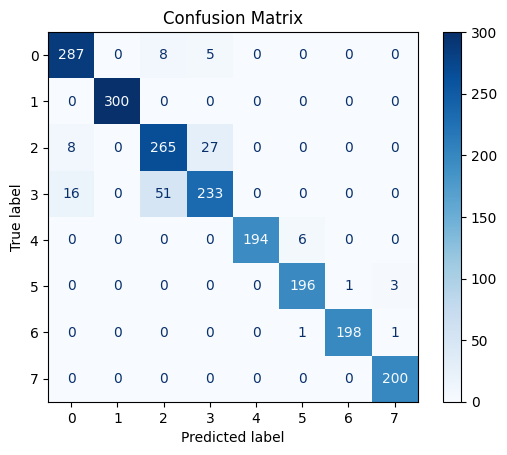

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm=confusion_matrix(y_true,y_pred_class)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [27]:
class_labels=list(val_data.class_indices.keys())

In [28]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels,zero_division=1))

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.92      0.96      0.94       300
ModerateDemented       1.00      1.00      1.00       300
     NonDemented       0.82      0.88      0.85       300
VeryMildDemented       0.88      0.78      0.82       300
          glioma       1.00      0.97      0.98       200
      meningioma       0.97      0.98      0.97       200
         notumor       0.99      0.99      0.99       200
       pituitary       0.98      1.00      0.99       200

        accuracy                           0.94      2000
       macro avg       0.95      0.94      0.94      2000
    weighted avg       0.94      0.94      0.94      2000



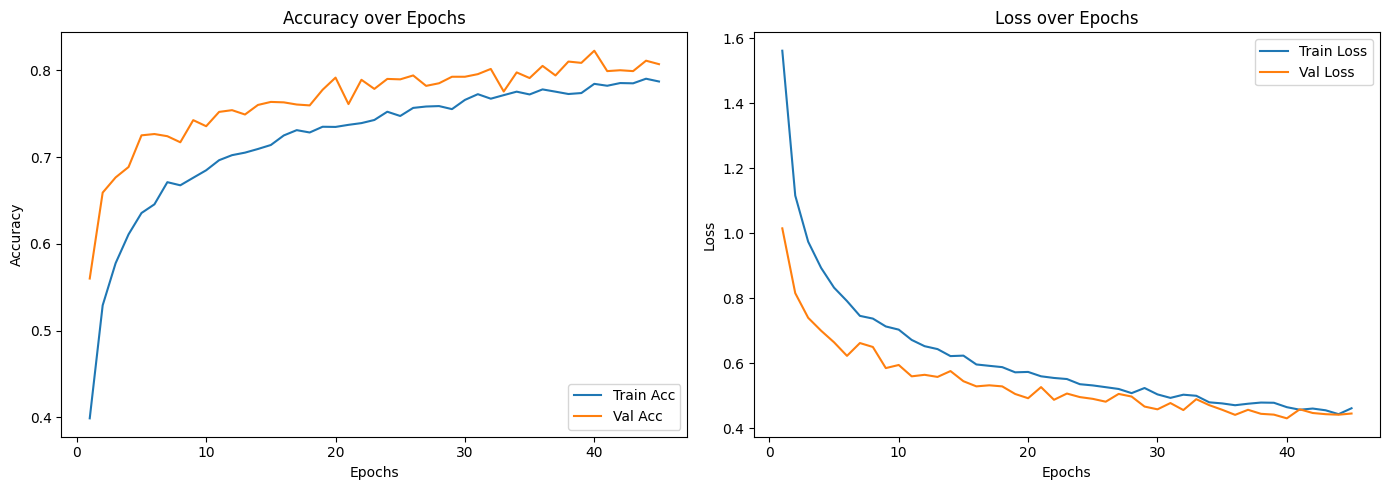

In [29]:
import matplotlib.pyplot as plt

acc1=history1.history['accuracy']
val_acc1=history1.history['val_accuracy']
loss1=history1.history['loss']
val_loss1=history1.history['val_loss']
epochs_range1=range(1,len(acc1)+1)


plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_range1,acc1,label='Train Acc')
plt.plot(epochs_range1,val_acc1,label='Val Acc')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(epochs_range1,loss1,label='Train Loss')
plt.plot(epochs_range1,val_loss1,label='Val Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves_feature_extraction.png",dpi=300)  
plt.show()

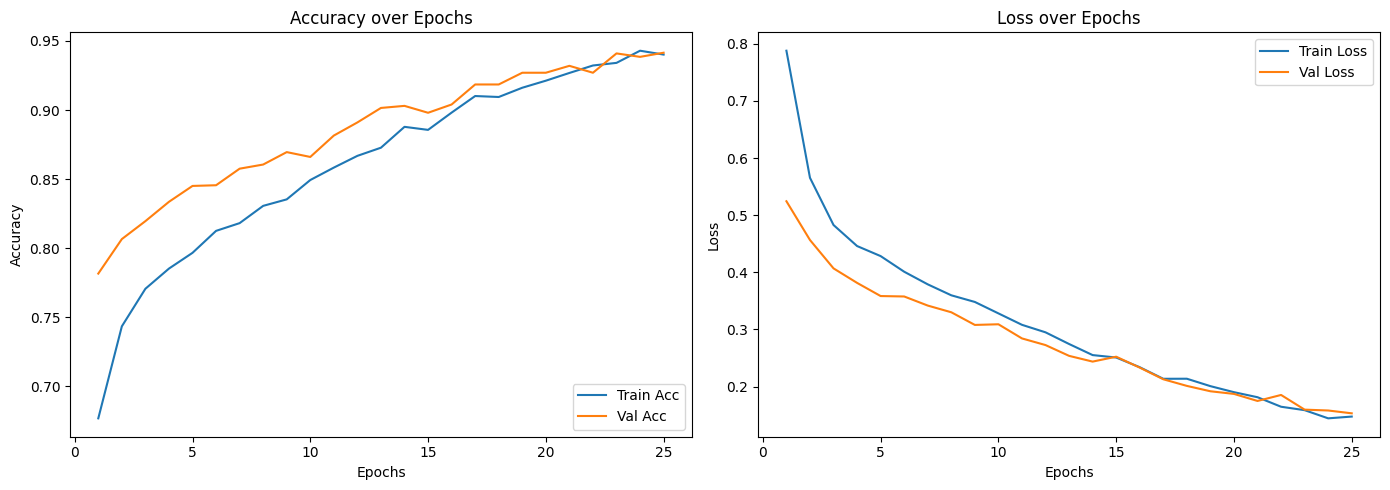

In [30]:
import matplotlib.pyplot as plt

acc2=history2.history['accuracy']
val_acc2=history2.history['val_accuracy']
loss2=history2.history['loss']
val_loss2=history2.history['val_loss']
epochs_range2=range(1,len(acc2)+1)


plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_range2,acc2,label='Train Acc')
plt.plot(epochs_range2,val_acc2,label='Val Acc')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(epochs_range2,loss2,label='Train Loss')
plt.plot(epochs_range2,val_loss2,label='Val Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves_fine_tuning.png",dpi=300)  
plt.show()

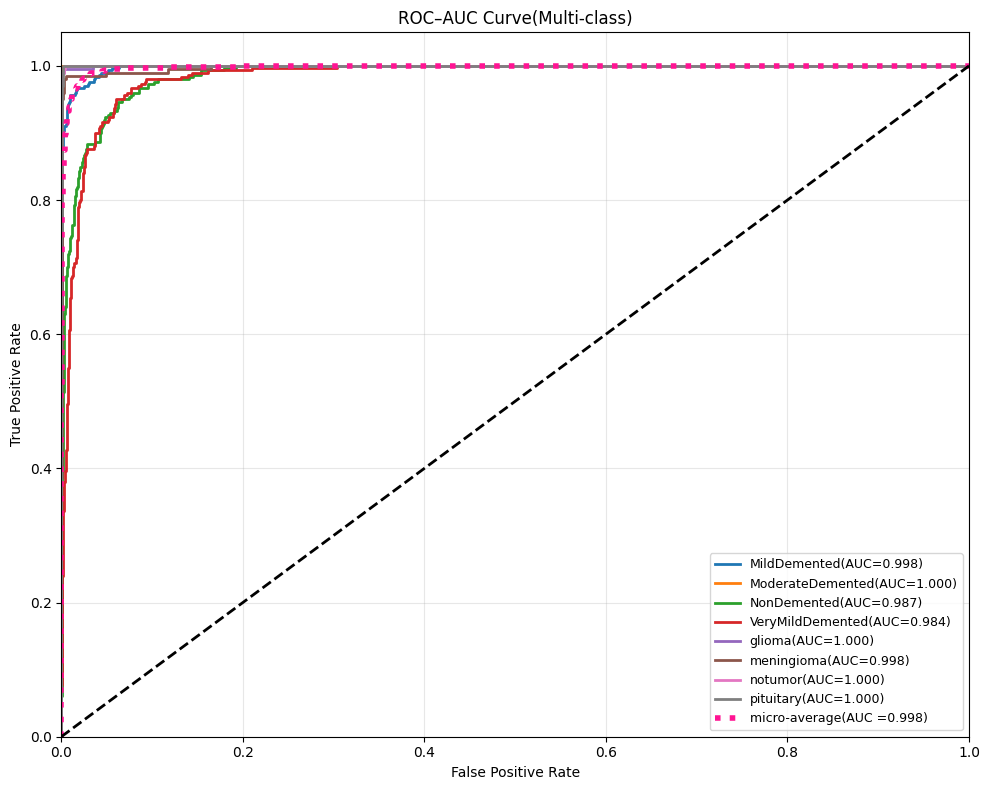


Macro-average ROC-AUC:0.9957
Weighted-average ROC-AUC:0.9950


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.preprocessing import label_binarize

num_classes=len(test_data.class_indices)
y_true_bin=label_binarize(y_true,classes=list(range(num_classes)))

fpr={}
tpr={}
roc_auc={}

for i in range(num_classes):
    fpr[i],tpr[i],_=roc_curve(y_true_bin[:,i],y_pred[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])

fpr["micro"],tpr["micro"],_=roc_curve(y_true_bin.ravel(),y_pred.ravel())
roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])
plt.figure(figsize=(10,8))

for i,class_name in enumerate(test_data.class_indices.keys()):
    plt.plot(fpr[i],tpr[i],lw=2,
             label=f"{class_name}(AUC={roc_auc[i]:.3f})")

plt.plot(fpr["micro"],tpr["micro"],
         label=f"micro-average(AUC ={roc_auc['micro']:.3f})",
         color="deeppink",linestyle=":",linewidth=4)


plt.plot([0,1],[0,1],"k--",lw=2)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve(Multi-class)")
plt.legend(loc="lower right",fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_auc_multiclass.png",dpi=300)
plt.show()

macro_roc_auc=roc_auc_score(y_true_bin,y_pred,average="macro",multi_class="ovr")
weighted_roc_auc=roc_auc_score(y_true_bin,y_pred,average="weighted",multi_class="ovr")
print(f"\nMacro-average ROC-AUC:{macro_roc_auc:.4f}")
print(f"Weighted-average ROC-AUC:{weighted_roc_auc:.4f}")

In [32]:
from tensorflow.keras.models import save_model
save_model(model,'ResNet152V2_WEIGHTS_BIASES_10k.keras')